In [12]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from datetime import datetime, date, time, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [13]:
# Useful functions
def flip(series: pd.Series) -> pd.Series:
    flipped = -series
    flipped[series == 0] = 0.0
    return flipped

def _bucket_time(ts):
    if ts is None or pd.isna(ts):
        return 'evening'

    if isinstance(ts, time):
        ts = datetime.combine(date.today(), ts)

    if not isinstance(ts, (pd.Timestamp, datetime)):
        ts = pd.to_datetime(ts)

    h = ts.hour
    if 9 <= h < 14:
        return 'aft'
    if 14 <= h < 19:
        return 'evening'
    return 'night'

In [ ]:
# Database connection and query
try:
    connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password="venomio",
        database="vpfm"
    )
    
    if connection.is_connected():       
        cursor = connection.cursor()

        cursor.execute(
            """
            SELECT 
                mi.match_id,
                mi.home_team_id,
                mi.away_team_id,
                mi.home_elevation_dif,
                mi.away_elevation_dif,
                mi.away_travel,
                mi.temperature_c,
                mi.is_raining,
                mi.date,
                sum(md.teamA_pdras) AS teamA_pdras,
                sum(md.teamB_pdras) AS teamB_pdras,
                sum(md.minutes_played) AS minutes_played,
                md.match_state,
                md.player_dif,
                (sum(md.teamA_headers) + sum(md.teamA_footers)) AS home_shots,
                (sum(md.teamB_headers) + sum(md.teamB_footers)) AS away_shots
            FROM match_info mi
            JOIN match_detail md 
                ON mi.match_id = md.match_id
            GROUP BY mi.match_id, md.match_state, md.player_dif
            """
            )
        column_names = [desc[0] for desc in cursor.description] 
        records = pd.DataFrame(cursor.fetchall(), columns=column_names)

        cursor.execute("""
            SELECT
                avg(temperature_c)
            FROM match_info
        """)
        temp = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
            
except Error as e:
    print(f"Error while connecting to MySQL: {e}")
    
finally:
    if connection.is_connected():
        cursor.close()
        connection.close()

records['date'] = pd.to_datetime(records['date'])
records['match_state'] = pd.to_numeric(records['match_state'], errors='raise').astype(float)
records['player_dif']  = pd.to_numeric(records['player_dif'],  errors='raise').astype(float)
records['minutes_played']  = pd.to_numeric(records['minutes_played'],  errors='raise').astype(int)
records['home_shots']  = pd.to_numeric(records['home_shots'],  errors='raise').astype(int)
records['away_shots']  = pd.to_numeric(records['away_shots'],  errors='raise').astype(int)
records.head()

,match_id,home_team_id,away_team_id,home_elevation_dif,away_elevation_dif,away_travel,temperature_c,is_raining,date,teamA_pdras,teamB_pdras,minutes_played,match_state,player_dif,home_shots,away_shots
0,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,6.540032,6.540032,45,0.0,0.0,6,8
1,4458,208,6,-174.0,-160.0,2994.0,19.0,0.0,2024-07-24 19:00:00,6.685372,6.685372,46,1.0,0.0,7,7
2,4459,97,211,222.0,266.0,1264.0,19.0,0.0,2024-07-24 19:00:00,12.789390,12.789390,88,0.0,0.0,12,7
3,4460,7,4,173.0,419.0,1491.0,14.0,0.0,2024-07-24 19:30:00,7.121362,7.121362,49,0.0,0.0,9,6
4,4460,7,4,173.0,419.0,1491.0,14.0,0.0,2024-07-24 19:30:00,6.104030,6.104030,42,-1.0,0.0,6,6


In [15]:
home_df = pd.DataFrame({
    'shots'              : records['home_shots'],
    'total_ras'          : records['teamA_pdras'],
    'minutes_played'     : records['minutes_played'],
    'team_is_home'       : 1,
    'team_elevation_dif' : records['home_elevation_dif'],
    'travel'             : -records['away_travel'],
    'match_state'        : records['match_state'],
    'player_dif'         : records['player_dif'],
    'temperature_dif'      : records['temperature_c'] - float(temp["avg(temperature_c)"][0]),
    'is_raining'         : records['is_raining'],
    'match_time'         : records['date'].apply(_bucket_time)
})

away_df = pd.DataFrame({
    'shots'              : records['away_shots'],
    'total_ras'          : records['teamB_pdras'],
    'minutes_played'     : records['minutes_played'],
    'team_is_home'       : 0,
    'team_elevation_dif' : records['away_elevation_dif'],
    'travel'             : records['away_travel'],
    'match_state'        : flip(records['match_state']),
    'player_dif'         : flip(records['player_dif']),
    'temperature_dif'      : records['temperature_c'] - float(temp["avg(temperature_c)"][0]),
    'is_raining'         : records['is_raining'],
    'match_time'         : records['date'].apply(_bucket_time)
})

df = pd.concat([home_df, away_df], ignore_index=True)
df

,shots,total_ras,minutes_played,team_is_home,team_elevation_dif,travel,match_state,player_dif,temperature_dif,is_raining,match_time
0,6,6.540032,45,1,-174.0,-2994.0,0.0,0.0,-1.5003,0.0,night
1,7,6.685372,46,1,-174.0,-2994.0,1.0,0.0,-1.5003,0.0,night
2,12,12.789390,88,1,222.0,-1264.0,0.0,0.0,-1.5003,0.0,night
3,9,7.121362,49,1,173.0,-1491.0,0.0,0.0,-6.5003,0.0,night
4,6,6.104030,42,1,173.0,-1491.0,-1.0,0.0,-6.5003,0.0,night
...,...,...,...,...,...,...,...,...,...,...,...
7931,1,1.478824,15,0,-29.0,1043.0,0.0,0.0,6.4997,1.0,night
7932,7,7.301424,65,0,374.0,144.0,0.0,0.0,-6.5003,0.0,evening
7933,0,0.459187,5,0,374.0,144.0,-1.0,0.0,-6.5003,0.0,evening
7934,1,2.280890,21,0,374.0,144.0,-1.5,0.0,-6.5003,0.0,evening


In [16]:
summary = df.describe(include="all").T
summary["mode"] = df.mode().values[0]
summary["n_unique"] = df.nunique()
summary["null_count"] = df.isnull().sum()
summary["skewness"] = df.skew(numeric_only=True)
summary["type"] = df.dtypes
summary.drop(columns=["unique", "top", "freq"], inplace=True)
summary

,count,mean,std,min,25%,50%,75%,max,mode,n_unique,null_count,skewness,type
shots,7936.0,5.179435,4.41014,0.0,2.0,4.0,8.0,34.0,2.0,30,0,1.207231,int32
total_ras,7936.0,5.236512,3.655393,0.079432,2.15856,4.535693,7.570604,19.76099,1.99502,7497,0,0.783984,float64
minutes_played,7936.0,37.903226,25.232503,1.0,15.0,31.0,57.0,103.0,15.0,102,0,0.536135,int32
team_is_home,7936.0,0.5,0.500032,0.0,0.0,0.5,1.0,1.0,0,2,0,0.000000,int64
team_elevation_dif,7908.0,-5.459661,435.366637,-2076.0,-146.0,-56.0,165.0,1928.0,-53.0,934,28,-0.005263,float64
travel,7908.0,0.0,1261.611554,-7517.0,-745.0,0.0,745.0,7517.0,-0.0,1467,28,0.000000,float64
match_state,7936.0,0.0,0.908547,-1.5,-1.0,0.0,1.0,1.5,0.0,5,0,0.000000,float64
player_dif,7936.0,0.0,0.285327,-1.5,0.0,0.0,0.0,1.5,0.0,5,0,0.000000,float64
temperature_dif,7684.0,0.030673,6.242503,-26.5003,-3.5003,0.4997,4.4997,18.4997,-1.5003,43,252,-0.374539,float64
is_raining,7684.0,0.188183,0.390884,0.0,0.0,0.0,0.0,1.0,0.0,2,252,1.595860,float64


In [ ]:
df_clean = df.copy()

df_clean = df_clean[df_clean['minutes_played'] >= 10]

df_clean['shots90']           = (df_clean['shots']      / df_clean['minutes_played']) * 90
df_clean['ras90']             = (df_clean['total_ras']  / df_clean['minutes_played']) * 90

cat_cols  = ['match_state', 'player_dif']
bool_cols = ['team_is_home']
num_cols  = ['team_elevation_dif', 'travel']
      
required_cols = cat_cols + bool_cols + num_cols + ['shots90', 'ras90']
missing_cols  = [c for c in ['shots90', 'ras90'] if c not in df_clean.columns]
if missing_cols:
    raise ValueError(f'Missing expected columns: {missing_cols}')

df_clean = df_clean.dropna(subset=[c for c in required_cols if c in df_clean.columns])

sample_weights = np.sqrt(df_clean['minutes_played'] / df['minutes_played'].max())

for c in cat_cols:
    df_clean[c] = df_clean[c].astype(str).str.lower()

df_clean[bool_cols] = df_clean[bool_cols].astype(int)

X_cat = pd.get_dummies(df_clean[cat_cols], prefix=cat_cols)
X     = pd.concat([df_clean[num_cols], df_clean[bool_cols], X_cat], axis=1)

y           = df_clean['shots90']
base_margin = np.log(df_clean['ras90'].clip(lower=0.1))

dtrain = xgb.DMatrix(X, label=y, base_margin=base_margin, weight=sample_weights)

params = dict(objective='count:poisson',
                tree_method='hist',
                max_depth=4,
                eta=0.03,
                subsample=1.0,
                colsample_bytree=1.0,
                min_child_weight=15,
                gamma=1,
                reg_alpha=0.5,
                reg_lambda=1.5,
                max_delta_step=1)  

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=50,
    metrics='poisson-nloglik',
    verbose_eval=False
)

optimal_rounds = len(cv_results)
booster = xgb.train(params, dtrain, num_boost_round=optimal_rounds)

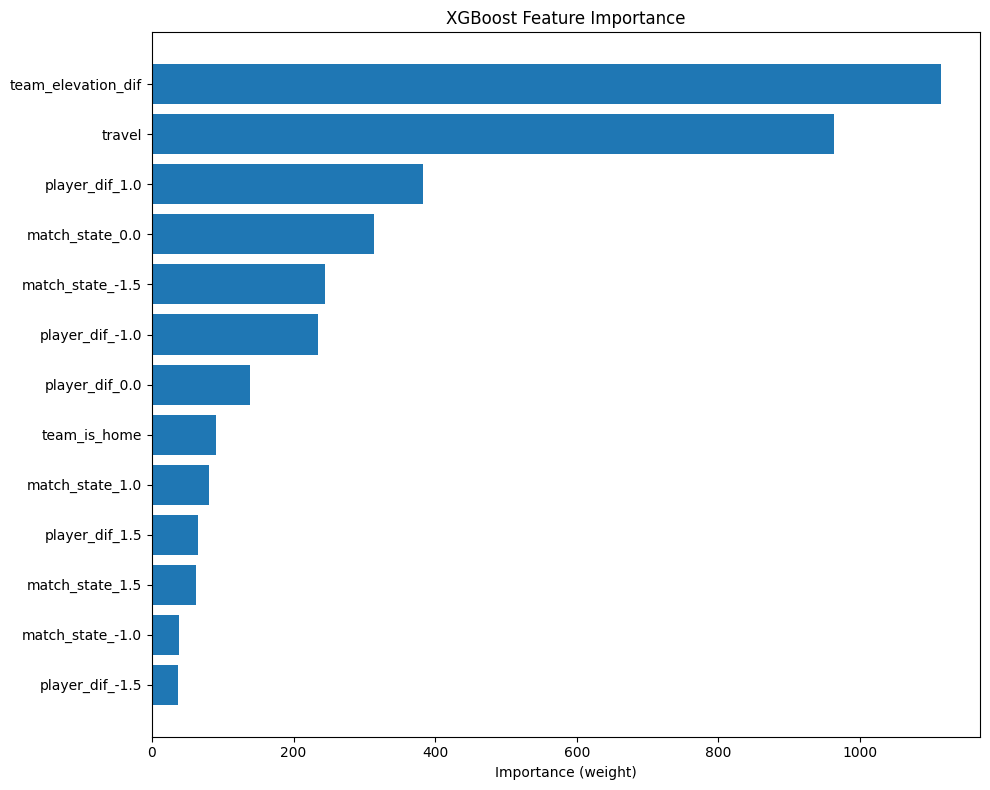

Feature Importance Scores:
               feature  importance
0   team_elevation_dif      1114.0
1               travel       963.0
11      player_dif_1.0       383.0
5      match_state_0.0       314.0
4     match_state_-1.5       244.0
8      player_dif_-1.0       235.0
10      player_dif_0.0       139.0
2         team_is_home        91.0
6      match_state_1.0        80.0
12      player_dif_1.5        65.0
7      match_state_1.5        62.0
3     match_state_-1.0        38.0
9      player_dif_-1.5        37.0


In [18]:
# Feature Importance
importance_scores = booster.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
}).sort_values('importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance (weight)')
plt.tight_layout()
plt.show()

# Print importance scores
print("Feature Importance Scores:")
print(importance_df.sort_values('importance', ascending=False))

C:\Users\markg\AppData\Local\Temp\ipykernel_18276\3232184934.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


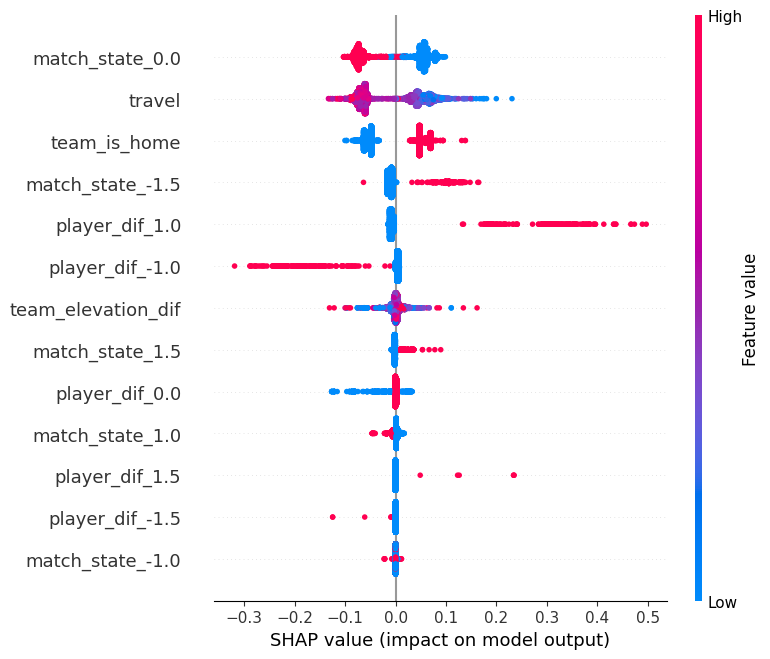

In [19]:
import shap

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X)

# Get mean absolute SHAP values
shap_importance = np.abs(shap_values).mean(0)

In [20]:
# Generate predictions
predictions = booster.predict(dtrain)

# Your existing code for model predictions
df_clean['predicted_shots90'] = predictions

# Calculate metrics for your model
mae_model = mean_absolute_error(df_clean['shots90'], predictions)
rmse_model = np.sqrt(mean_squared_error(df_clean['shots90'], predictions))

# Calculate metrics using ras90 as the prediction
mae_ras90 = mean_absolute_error(df_clean['shots90'], df_clean['ras90'])
rmse_ras90 = np.sqrt(mean_squared_error(df_clean['shots90'], df_clean['ras90']))

print(f"\nModel Performance vs RAS90 Baseline:")
print(f"MAE - Model: {mae_model:.4f}, RAS90: {mae_ras90:.4f}")
print(f"RMSE - Model: {rmse_model:.4f}, RAS90: {rmse_ras90:.4f}")

# Calculate improvement percentages
mae_improvement = ((mae_ras90 - mae_model) / mae_ras90) * 100
rmse_improvement = ((rmse_ras90 - rmse_model) / rmse_ras90) * 100

print(f"\nImprovement over RAS90:")
print(f"MAE improvement: {mae_improvement:.2f}%")
print(f"RMSE improvement: {rmse_improvement:.2f}%")

# You can also compare side-by-side in a dataframe
comparison = pd.DataFrame({
    'actual_shots90': df_clean['shots90'],
    'predicted_shots90': predictions,
    'ras90_prediction': df_clean['ras90']
})

print("\nComparison sample:")
print(comparison.tail(20))

# What this improvement means in practical terms
avg_shots90 = df_clean['shots90'].mean()
print(f"Average shots90: {avg_shots90:.2f}")
print(f"Model error rate: {(mae_model/avg_shots90)*100:.1f}%")
print(f"RAS90 error rate: {(mae_ras90/avg_shots90)*100:.1f}%")


Model Performance vs RAS90 Baseline:
MAE - Model: 5.3332, RAS90: 5.6707
RMSE - Model: 7.0977, RAS90: 7.5331

Improvement over RAS90:
MAE improvement: 5.95%
RMSE improvement: 5.78%

Comparison sample:
      actual_shots90  predicted_shots90  ras90_prediction
7911       12.857143          10.438562         13.176077
7912        6.585366          12.454047         13.525983
7913        8.035714          10.539755         13.446942
7914       24.545455          13.119236         14.570164
7915       14.625000          11.104922         14.410354
7916       21.272727          12.514627         13.206241
7917        0.000000          14.024055         13.776317
7918        6.000000          10.714779         13.229610
7919       12.134831          14.501001         15.749123
7922       14.464286          12.515317         11.921952
7924        0.000000          10.626893         11.701166
7925        0.000000           9.267698         11.701165
7926        7.058824          15.820220      

In [23]:
def predict_shots_simple(model, features_dict, ras90_value):
    """
    Corrected predictor that handles feature alignment properly
    """
    # Create base margin (same as training)
    base_margin = np.log(max(ras90_value, 0.1))
    
    # Convert to DataFrame
    feature_df = pd.DataFrame([features_dict])
    
    # Apply same preprocessing as training
    cat_cols = ['match_state', 'player_dif']
    for col in cat_cols:
        feature_df[col] = feature_df[col].astype(str).str.lower()
    
    bool_cols = ['team_is_home']
    for col in bool_cols:
        feature_df[col] = feature_df[col].astype(int)
    
    # One-hot encode categoricals
    X_cat = pd.get_dummies(feature_df[cat_cols], prefix=cat_cols)
    X_num_bool = feature_df[['team_elevation_dif', 'travel'] + bool_cols]
    X_input = pd.concat([X_num_bool, X_cat], axis=1)
    
    # CRITICAL: Align with training columns exactly
    # Get the expected columns from the training data
    training_columns = X.columns
    
    # Reindex to match training columns, fill missing with 0
    X_input = X_input.reindex(columns=training_columns, fill_value=0)
    
    # Ensure column order matches exactly
    X_input = X_input[training_columns]
    
    # Predict
    dinput = xgb.DMatrix(X_input, base_margin=[base_margin])
    return model.predict(dinput)[0]

# Test with data that matches your training format
sample_features = {
    'match_state': '0.0',           # Convert to string to match training preprocessing
    'player_dif': '0.0',            # Convert to string to match training preprocessing
    'team_is_home': 1,
    'team_elevation_dif': -500,
    'travel': -2994,
}

prediction = predict_shots_simple(booster, sample_features, ras90_value=13.28)
print(f"Predicted shots per 90: {prediction:.2f}")

Predicted shots per 90: 14.33
